In [ ]:
import os
import re
import json
import random
import time
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ------------------------
# 0) Settings & Seeds
# ------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TRAIN_PATH = 'lr_imputed_train.csv'
TEST_PATH  = 'lr_imputed_test.csv'
OUT_DIR = './models_and_results'
os.makedirs(OUT_DIR, exist_ok=True)

# Hyperparams (tune if you want)
MAX_LEN = 200        # max chars for sequence models
EMBED_DIM = 64
BATCH = 128
EPOCHS = 20

In [4]:
# ------------------------
# 1) Load data
# ------------------------
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# Attempt to detect label and url columns
possible_label_cols = ['label', 'Label', 'y', 'is_phish', 'phishing']
possible_url_cols = ['url', 'URL', 'link']
label_col = None
url_col = None

for c in train_df.columns:
    if c in possible_label_cols:
        label_col = c
        break
if label_col is None:
    # fallback to last column as label
    label_col = train_df.columns[-1]

for c in train_df.columns:
    if c in possible_url_cols:
        url_col = c
        break
if url_col is None:
    # fallback to first column as url string
    url_col = train_df.columns[0]

print("Detected columns — url_col:", url_col, "label_col:", label_col)

# Ensure label is numeric 0/1
train_df[label_col] = train_df[label_col].astype(int)
test_df[label_col]  = test_df[label_col].astype(int)

# Inspect if engineered features already exist (columns beyond url and label)
engineered_cols = [c for c in train_df.columns if c not in [url_col, label_col]]
print("Extra columns found in train:", engineered_cols[:10])

Detected columns — url_col: url label_col: status
Extra columns found in train: ['age', 'num_suspicious_words', 'has_ip_address', 'is_url_shortened', 'length', 'subdomain_ratio', 'num_dots', 'num_www', 'num_dcom', 'num_http']


In [5]:
# ------------------------
# 2) Feature construction helpers (if no engineered features)
# ------------------------
def extract_lexical_features(url: str):
    u = str(url)
    f = {}
    f['url_length'] = len(u)
    parsed = re.sub(r'https?://', '', u, flags=re.I)
    f['num_dots'] = parsed.count('.')
    f['num_hyphens'] = parsed.count('-')
    f['num_underscores'] = parsed.count('_')
    f['num_digits'] = sum(c.isdigit() for c in u)
    f['num_params'] = u.count('?')
    f['has_at'] = 1 if '@' in u else 0
    f['has_ip'] = 1 if re.search(r'://\d+\.\d+\.\d+\.\d+', u) else 0
    f['is_http'] = 1 if u.lower().startswith('http://') else 0
    f['is_https'] = 1 if u.lower().startswith('https://') else 0
    f['has_login_keyword'] = int(bool(re.search(r'login|signin|secure|account|update', u, re.I)))
    return f

def build_engineered_df(df, url_col=url_col):
    features = [extract_lexical_features(u) for u in df[url_col].astype(str).tolist()]
    feat_df = pd.DataFrame(features)
    return feat_df

# Build or take existing tabular features
if len(engineered_cols) <= 2:  # likely only url & label -> build features
    print("No or few engineered features found. Building lexical features...")
    X_train_tab = build_engineered_df(train_df, url_col)
    X_test_tab  = build_engineered_df(test_df, url_col)
else:
    # Use all columns except url and label as tabular features
    X_train_tab = train_df.drop(columns=[url_col, label_col]).reset_index(drop=True)
    X_test_tab  = test_df.drop(columns=[url_col, label_col]).reset_index(drop=True)

y_train_full = train_df[label_col].values
y_test = test_df[label_col].values

In [6]:
# ------------------------
# 3) Build char tokenizer & encode sequences
# ------------------------
def build_char_vocabulary(urls):
    chars = sorted(set(''.join(urls)))
    char_to_id = {c: i+1 for i,c in enumerate(chars)}  # 0 reserved for padding/unknown
    return char_to_id

def encode_urls(urls, char_to_id, maxlen=MAX_LEN):
    enc = []
    for u in urls:
        ids = [char_to_id.get(c, 0) for c in str(u)[:maxlen]]
        if len(ids) < maxlen:
            ids = ids + [0]*(maxlen - len(ids))
        enc.append(ids)
    return np.array(enc, dtype=np.int32)

all_urls = pd.concat([train_df[url_col], test_df[url_col]]).astype(str).tolist()
char_to_id = build_char_vocabulary(all_urls)
vocab_size = len(char_to_id) + 1
print("Char vocab size:", vocab_size)

X_train_seq = encode_urls(train_df[url_col].astype(str).tolist(), char_to_id, MAX_LEN)
X_test_seq  = encode_urls(test_df[url_col].astype(str).tolist(), char_to_id, MAX_LEN)

Char vocab size: 92


In [7]:
# ------------------------
# 4) Standardize tabular features
# ------------------------
scaler = StandardScaler()
X_train_tab_arr = scaler.fit_transform(X_train_tab.values)
X_test_tab_arr  = scaler.transform(X_test_tab.values)

joblib.dump(scaler, os.path.join(OUT_DIR, 'scaler_tab.pkl'))
with open(os.path.join(OUT_DIR, 'char_to_id.json'), 'w') as f:
    json.dump(char_to_id, f)

In [8]:
# ------------------------
# 5) Train/Val split (use train_df to make train/val)
# ------------------------
# We'll use the provided train.csv for train+val; keep test.csv untouched until final eval.
train_idx, val_idx = train_test_split(np.arange(len(train_df)), test_size=0.15, stratify=y_train_full, random_state=SEED)
X_tr_tab, X_val_tab = X_train_tab_arr[train_idx], X_train_tab_arr[val_idx]
X_tr_seq, X_val_seq = X_train_seq[train_idx], X_train_seq[val_idx]
y_tr, y_val = y_train_full[train_idx], y_train_full[val_idx]

# For final test:
X_final_tab = X_test_tab_arr
X_final_seq = X_test_seq
y_final = y_test

In [9]:
# ------------------------
# 6) Define Keras models
# ------------------------
def build_mlp_tab(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def build_cnn_seq(vocab_size, max_len):
    inp = Input(shape=(max_len,))
    x = Embedding(vocab_size, EMBED_DIM, input_length=max_len)(inp)
    convs = []
    for k in [3,4,5]:
        c = Conv1D(128, k, activation='relu')(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)
    x = Concatenate()(convs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def build_bilstm_seq(vocab_size, max_len):
    inp = Input(shape=(max_len,))
    x = Embedding(vocab_size, EMBED_DIM, input_length=max_len)(inp)
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def build_transformer(vocab_size, max_len, embed_dim=EMBED_DIM):
    # small transformer encoder stack
    inp = Input(shape=(max_len,))
    x = Embedding(vocab_size, embed_dim, input_length=max_len)(inp)
    # single MultiHead layer via Keras MultiHeadAttention with feedforward
    # Add positional encoding implicitly by index embedding not added here for simplicity
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)
    ff = layers.Dense(128, activation='relu')(x)
    ff = layers.Dense(embed_dim)(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

def build_hybrid_cnn_tab(vocab_size, max_len, tab_input_dim):
    # Sequence branch (CNN)
    seq_in = Input(shape=(max_len,), name='seq_in')
    emb = Embedding(vocab_size, EMBED_DIM, input_length=max_len)(seq_in)
    conv_pools = []
    for k in [3,4,5]:
        c = Conv1D(128, k, activation='relu')(emb)
        p = GlobalMaxPooling1D()(c)
        conv_pools.append(p)
    seq_branch = Concatenate()(conv_pools)
    seq_branch = Dense(64, activation='relu')(seq_branch)

    # Tabular branch
    tab_in = Input(shape=(tab_input_dim,), name='tab_in')
    tab_branch = Dense(128, activation='relu')(tab_in)
    tab_branch = Dropout(0.3)(tab_branch)
    tab_branch = Dense(64, activation='relu')(tab_branch)

    # Combine
    combined = Concatenate()([seq_branch, tab_branch])
    combined = Dropout(0.4)(combined)
    combined = Dense(64, activation='relu')(combined)
    out = Dense(1, activation='sigmoid')(combined)
    model = Model(inputs=[seq_in, tab_in], outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model



In [10]:
# ------------------------
# 7) Train each model and evaluate on val
# ------------------------
results = []

def evaluate_and_log(name, model, X_val_inputs, y_val, X_test_inputs, y_test, save_path=None):
    # X_val_inputs and X_test_inputs can be arrays or dicts (for hybrid)
    y_val_pred = model.predict(X_val_inputs, batch_size=BATCH).ravel()
    y_test_pred = model.predict(X_test_inputs, batch_size=BATCH).ravel()
    val_auc = roc_auc_score(y_val, y_val_pred)
    val_pr = average_precision_score(y_val, y_val_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    test_pr = average_precision_score(y_test, y_test_pred)
    print(f"\n{name} — VAL ROC-AUC: {val_auc:.4f}, VAL PR-AUC: {val_pr:.4f}")
    print(f"{name} — TEST ROC-AUC: {test_auc:.4f}, TEST PR-AUC: {test_pr:.4f}")
    y_test_pred_label = (y_test_pred >= 0.5).astype(int)
    print(classification_report(y_test, y_test_pred_label))
    results.append({
        'model': name,
        'val_auc': float(val_auc),
        'val_pr': float(val_pr),
        'test_auc': float(test_auc),
        'test_pr': float(test_pr)
    })
    if save_path:
        model.save(save_path)
    return y_val_pred, y_test_pred

# 7A) MLP on tabular
mlp = build_mlp_tab(X_tr_tab.shape[1])
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mlp.fit(X_tr_tab, y_tr, validation_data=(X_val_tab, y_val), epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)
yval_mlp, ytest_mlp = evaluate_and_log('MLP_Tabular', mlp, X_val_tab, y_val, X_final_tab, y_final,
                                       save_path=os.path.join(OUT_DIR, 'mlp_tab.h5'))
joblib.dump(mlp, os.path.join(OUT_DIR, 'mlp_tab_joblib.pkl'))  # works for sklearn objects; keras model saved above

# 7B) CNN on sequences
cnn = build_cnn_seq(vocab_size, MAX_LEN)
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
cnn.fit(X_tr_seq, y_tr, validation_data=(X_val_seq, y_val), epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)
yval_cnn, ytest_cnn = evaluate_and_log('CNN_Seq', cnn, X_val_seq, y_val, X_final_seq, y_final, save_path=os.path.join(OUT_DIR, 'cnn_seq.h5'))

# 7C) Bi-LSTM on sequences
lstm = build_bilstm_seq(vocab_size, MAX_LEN)
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lstm.fit(X_tr_seq, y_tr, validation_data=(X_val_seq, y_val), epochs=EPOCHS, batch_size=BATCH//2, callbacks=[es], verbose=1)
yval_lstm, ytest_lstm = evaluate_and_log('BiLSTM_Seq', lstm, X_val_seq, y_val, X_final_seq, y_final, save_path=os.path.join(OUT_DIR, 'bilstm_seq.h5'))

# 7D) Hybrid (CNN + Tabular)
hybrid = build_hybrid_cnn_tab(vocab_size, MAX_LEN, X_tr_tab.shape[1])
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
hybrid.fit({'seq_in': X_tr_seq, 'tab_in': X_tr_tab}, y_tr,
           validation_data=({'seq_in': X_val_seq, 'tab_in': X_val_tab}, y_val),
           epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)
yval_hybrid, ytest_hybrid = evaluate_and_log('Hybrid_CNN_Tab', hybrid, {'seq_in': X_val_seq, 'tab_in': X_val_tab}, y_val,
                                             {'seq_in': X_final_seq, 'tab_in': X_final_tab}, y_final,
                                             save_path=os.path.join(OUT_DIR, 'hybrid.h5'))

# 7E) Small Transformer on sequences
trans = build_transformer(vocab_size, MAX_LEN, embed_dim=EMBED_DIM)
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
trans.fit(X_tr_seq, y_tr, validation_data=(X_val_seq, y_val), epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)
yval_trans, ytest_trans = evaluate_and_log('Transformer_Seq', trans, X_val_seq, y_val, X_final_seq, y_final, save_path=os.path.join(OUT_DIR, 'trans_seq.h5'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - auc: 0.8060 - loss: 0.5263 - val_auc: 0.9494 - val_loss: 0.2821
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9414 - loss: 0.3044 - val_auc: 0.9582 - val_loss: 0.2602
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9528 - loss: 0.2743 - val_auc: 0.9622 - val_loss: 0.2462
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9571 - loss: 0.2613 - val_auc: 0.9653 - val_loss: 0.2356
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9614 - loss: 0.2486 - val_auc: 0.9666 - val_loss: 0.2303
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9638 - loss: 0.2408 - val_auc: 0.9679 - val_loss: 0.2259
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9660 - loss: 0.2329 - val_auc: 0.9693 - val_loss: 0.2196
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9677 - loss: 0.2261 - val_auc: 0.9703 - val_loss: 0.2143
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9699 - loss:


MLP_Tabular — VAL ROC-AUC: 0.9768, VAL PR-AUC: 0.9715
MLP_Tabular — TEST ROC-AUC: 0.9758, TEST PR-AUC: 0.9673
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2071
           1       0.92      0.91      0.91      1470

    accuracy                           0.93      3541
   macro avg       0.93      0.93      0.93      3541
weighted avg       0.93      0.93      0.93      3541

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - auc: 0.7414 - loss: 0.5770 - val_auc: 0.9135 - val_loss: 0.3703
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9259 - loss: 0.3394 - val_auc: 0.9399 - val_loss: 0.3140
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9515 - loss: 0.2744 - val_auc: 0.9540 - val_loss: 0.2787
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9652 - loss: 0.2326 - val_auc: 0.9618 - val_loss: 0.2606
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9729 - loss: 0.2060 - val_auc: 0.9665 - val_loss: 0.2501
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9780 - loss: 0.1836 - val_auc: 0.9698 - val_loss: 0.2684
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9789 - loss: 0.1832 - val_auc: 0.9708 - val_loss: 0.2370
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9835 - loss: 0.1598 - val_auc: 0.9735 - val_loss: 0.2072
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9862 - loss: 0.1447


CNN_Seq — VAL ROC-AUC: 0.9791, VAL PR-AUC: 0.9771
CNN_Seq — TEST ROC-AUC: 0.9818, TEST PR-AUC: 0.9767
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2071
           1       0.94      0.91      0.93      1470

    accuracy                           0.94      3541
   macro avg       0.94      0.93      0.94      3541
weighted avg       0.94      0.94      0.94      3541



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - auc: 0.7567 - loss: 0.5689 - val_auc: 0.8835 - val_loss: 0.4286
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc: 0.8887 - loss: 0.4146 - val_auc: 0.9120 - val_loss: 0.3952
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - auc: 0.9182 - loss: 0.3569 - val_auc: 0.9221 - val_loss: 0.3507
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.9130 - loss: 0.3680 - val_auc: 0.9195 - val_loss: 0.3577
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.9281 - loss: 0.3344 - val_auc: 0.9261 - val_loss: 0.3413
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - auc: 0.9349 - loss: 0.3186 - val_auc: 0.9296 - val_loss: 0.3320
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.9381 - loss: 0.3115 - val_auc: 0.9297 - val_loss: 0.3430
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - auc: 0.9332 - loss: 0.3225 - val_auc: 0.9358 - val_loss: 0.3191
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms


BiLSTM_Seq — VAL ROC-AUC: 0.9552, VAL PR-AUC: 0.9484
BiLSTM_Seq — TEST ROC-AUC: 0.9611, TEST PR-AUC: 0.9521
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2071
           1       0.89      0.88      0.89      1470

    accuracy                           0.91      3541
   macro avg       0.90      0.90      0.90      3541
weighted avg       0.91      0.91      0.91      3541

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - auc: 0.8287 - loss: 0.4931 - val_auc: 0.9653 - val_loss: 0.2367
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9663 - loss: 0.2319 - val_auc: 0.9782 - val_loss: 0.1927
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9802 - loss: 0.1762 - val_auc: 0.9826 - val_loss: 0.1610
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9886 - loss: 0.1328 - val_auc: 0.9856 - val_loss: 0.1468
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9927 - loss: 0.1052 - val_auc: 0.9865 - val_loss: 0.1439
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9949 - loss: 0.0818 - val_auc: 0.9835 - val_loss: 0.1732
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9968 - loss: 0.0669 - val_auc: 0.9832 - val_loss: 0.2076
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9968 - loss: 0.0687 - val_auc: 0.9822 - val_loss: 0.1956
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9951 - loss: 0


Hybrid_CNN_Tab — VAL ROC-AUC: 0.9872, VAL PR-AUC: 0.9846
Hybrid_CNN_Tab — TEST ROC-AUC: 0.9886, TEST PR-AUC: 0.9853
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2071
           1       0.95      0.93      0.94      1470

    accuracy                           0.95      3541
   macro avg       0.95      0.95      0.95      3541
weighted avg       0.95      0.95      0.95      3541

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - auc: 0.6350 - loss: 0.6582 - val_auc: 0.7967 - val_loss: 0.5412
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.7718 - loss: 0.5581 - val_auc: 0.8109 - val_loss: 0.5216
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.7941 - loss: 0.5390 - val_auc: 0.8219 - val_loss: 0.5080
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8103 - loss: 0.5201 - val_auc: 0.8223 - val_loss: 0.5158
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8208 - loss: 0.5089 - val_auc: 0.8350 - val_loss: 0.4916
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - auc: 0.8416 - loss: 0.4827 - val_auc: 0.8728 - val_loss: 0.4772
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8711 - loss: 0.4443 - val_auc: 0.8861 - val_loss: 0.4299
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8862 - loss: 0.4169 - val_auc: 0.8918 - val_loss: 0.4178
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8924 - loss: 0


Transformer_Seq — VAL ROC-AUC: 0.9189, VAL PR-AUC: 0.9045
Transformer_Seq — TEST ROC-AUC: 0.9243, TEST PR-AUC: 0.9043
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2071
           1       0.84      0.80      0.82      1470

    accuracy                           0.86      3541
   macro avg       0.85      0.85      0.85      3541
weighted avg       0.85      0.86      0.85      3541



In [11]:
# ------------------------
# 8) Simple stacking ensemble (meta-logistic using validation predictions)
# ------------------------
# Collect val predictions from base models (for the train/val split)
# Note: We already have yval_* arrays above (val preds for each model)
val_preds = np.vstack([yval_mlp, yval_cnn, yval_lstm, yval_hybrid, yval_trans]).T
test_preds = np.vstack([ytest_mlp, ytest_cnn, ytest_lstm, ytest_hybrid, ytest_trans]).T

meta = LogisticRegression(max_iter=1000)
meta.fit(val_preds, y_val)  # train meta on val preds
meta_test_proba = meta.predict_proba(test_preds)[:,1]
print("\nStacking meta results:")
print("Stack ROC-AUC:", roc_auc_score(y_final, meta_test_proba))
print("Stack PR-AUC:", average_precision_score(y_final, meta_test_proba))
print(classification_report(y_final, (meta_test_proba >= 0.5).astype(int)))

results.append({'model':'Stacking_Meta', 'val_auc': None, 'val_pr': None,
                'test_auc': float(roc_auc_score(y_final, meta_test_proba)),
                'test_pr': float(average_precision_score(y_final, meta_test_proba))})

# 8B) Simple average ensemble of top 3 (choose best by val PR or AUC)
# We'll average hybrid, cnn, and mlp as example
avg_proba = (ytest_hybrid + ytest_cnn + ytest_mlp) / 3.0
print("\nSimple average ensemble (Hybrid+CNN+MLP):")
print("Avg ROC-AUC:", roc_auc_score(y_final, avg_proba))
print("Avg PR-AUC:", average_precision_score(y_final, avg_proba))
print(classification_report(y_final, (avg_proba>=0.5).astype(int)))

results.append({'model':'AvgEnsemble_Hybrid_CNN_MLP', 'val_auc': None, 'val_pr': None,
                'test_auc': float(roc_auc_score(y_final, avg_proba)),
                'test_pr': float(average_precision_score(y_final, avg_proba))})


Stacking meta results:
Stack ROC-AUC: 0.9908490098115538
Stack PR-AUC: 0.9885957353611472
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2071
           1       0.96      0.95      0.95      1470

    accuracy                           0.96      3541
   macro avg       0.96      0.96      0.96      3541
weighted avg       0.96      0.96      0.96      3541


Simple average ensemble (Hybrid+CNN+MLP):
Avg ROC-AUC: 0.990246257846451
Avg PR-AUC: 0.9878826341025004
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2071
           1       0.96      0.94      0.95      1470

    accuracy                           0.96      3541
   macro avg       0.96      0.96      0.96      3541
weighted avg       0.96      0.96      0.96      3541



In [12]:
# ------------------------
# 9) Train a RandomForest on tabular and calibrate it (example of calibration)
# ------------------------
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED)
rf.fit(X_tr_tab, y_tr)
rf_val_pred = rf.predict_proba(X_val_tab)[:,1]
rf_test_pred = rf.predict_proba(X_final_tab)[:,1]
print("\nRF - TEST ROC-AUC:", roc_auc_score(y_final, rf_test_pred), "PR-AUC:", average_precision_score(y_final, rf_test_pred))

# Calibrate RF with validation data (Platt scaling)
calibrator = CalibratedClassifierCV(rf, method='sigmoid', cv='prefit')
calibrator.fit(X_val_tab, y_val)
rf_cal_test = calibrator.predict_proba(X_final_tab)[:,1]
print("Calibrated RF - TEST ROC-AUC:", roc_auc_score(y_final, rf_cal_test), "PR-AUC:", average_precision_score(y_final, rf_cal_test))

results.append({'model':'RandomForest', 'val_auc': None, 'val_pr': None,
                'test_auc': float(roc_auc_score(y_final, rf_test_pred)),
                'test_pr': float(average_precision_score(y_final, rf_test_pred))})
results.append({'model':'RandomForest_Calibrated', 'val_auc': None, 'val_pr': None,
                'test_auc': float(roc_auc_score(y_final, rf_cal_test)),
                'test_pr': float(average_precision_score(y_final, rf_cal_test))})

joblib.dump(rf, os.path.join(OUT_DIR, 'rf_tab.joblib'))
joblib.dump(calibrator, os.path.join(OUT_DIR, 'rf_calibrator.joblib'))


RF - TEST ROC-AUC: 0.9861475444837521 PR-AUC: 0.9816295458214044
Calibrated RF - TEST ROC-AUC: 0.9861475444837521 PR-AUC: 0.9816295458214044


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


['./models_and_results/rf_calibrator.joblib']

In [13]:
# ------------------------
# 10) Save results & error analysis
# ------------------------
res_df = pd.DataFrame(results)
res_df.to_csv(os.path.join(OUT_DIR, 'models_summary.csv'), index=False)
print("\nSaved models summary to", os.path.join(OUT_DIR, 'models_summary.csv'))
print(res_df)

# Write out false positives and false negatives for the best model (choose stacking or avg)
best_proba = meta_test_proba  # meta stack chosen here; change to avg_proba or rf_cal_test if you prefer
pred_label = (best_proba >= 0.5).astype(int)
test_urls = test_df[url_col].astype(str).reset_index(drop=True)

fp_mask = (pred_label == 1) & (y_final == 0)
fn_mask = (pred_label == 0) & (y_final == 1)
pd.DataFrame({'url': test_urls[fp_mask], 'pred_prob': best_proba[fp_mask], 'true_label': y_final[fp_mask]}).to_csv(os.path.join(OUT_DIR, 'false_positives_meta.csv'), index=False)
pd.DataFrame({'url': test_urls[fn_mask], 'pred_prob': best_proba[fn_mask], 'true_label': y_final[fn_mask]}).to_csv(os.path.join(OUT_DIR, 'false_negatives_meta.csv'), index=False)
print("Saved false positive/negative lists.")


Saved models summary to ./models_and_results/models_summary.csv
                        model   val_auc    val_pr  test_auc   test_pr
0                 MLP_Tabular  0.976804  0.971472  0.975830  0.967329
1                     CNN_Seq  0.979092  0.977117  0.981792  0.976712
2                  BiLSTM_Seq  0.955187  0.948379  0.961115  0.952063
3              Hybrid_CNN_Tab  0.987186  0.984633  0.988634  0.985316
4             Transformer_Seq  0.918870  0.904471  0.924293  0.904327
5               Stacking_Meta       NaN       NaN  0.990849  0.988596
6  AvgEnsemble_Hybrid_CNN_MLP       NaN       NaN  0.990246  0.987883
7                RandomForest       NaN       NaN  0.986148  0.981630
8     RandomForest_Calibrated       NaN       NaN  0.986148  0.981630
Saved false positive/negative lists.


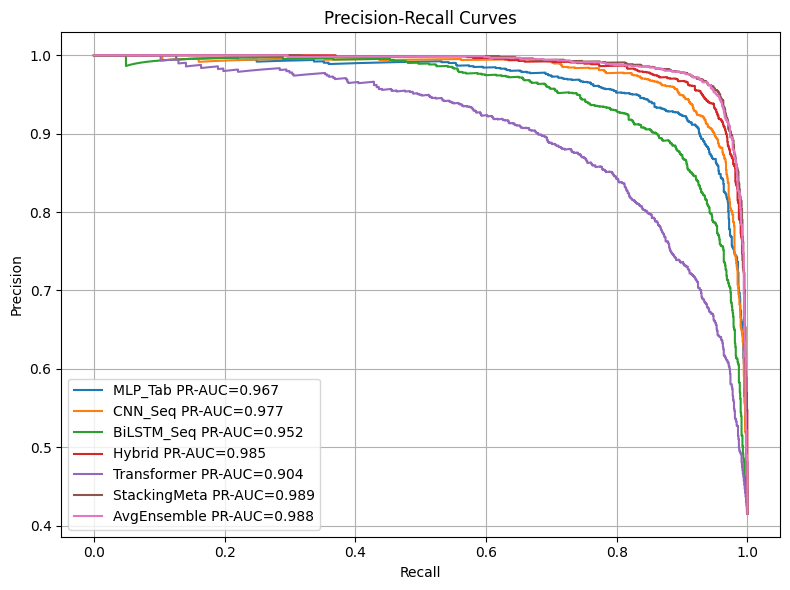

All done. Models, scalers, tokenizers and results saved to: ./models_and_results


In [14]:
# ------------------------
# 11) Plot PR curves for selected models (example)
# ------------------------
from sklearn.metrics import precision_recall_curve, auc
plt.figure(figsize=(8,6))
models_to_plot = {
    'MLP_Tab': ytest_mlp,
    'CNN_Seq': ytest_cnn,
    'BiLSTM_Seq': ytest_lstm,
    'Hybrid': ytest_hybrid,
    'Transformer': ytest_trans,
    'StackingMeta': meta_test_proba,
    'AvgEnsemble': avg_proba
}
for name, proba in models_to_plot.items():
    prec, rec, _ = precision_recall_curve(y_final, proba)
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name} PR-AUC={pr_auc:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'pr_curves.png'))
plt.show()

print("All done. Models, scalers, tokenizers and results saved to:", OUT_DIR)